# Lorenz System Lyapunov Exponents as $\rho$ changes
# (true system for paper version)

$$
\begin{split}
\dot{x} &= \sigma(y-x)\\
\dot{y} &= x(\rho-z)-y\\
\dot{z} &= xy - \beta z
\end{split}
$$

## $\sigma = 10, \beta = \frac{8}{3}$

### References
#### Papers
##### J. Fr$\text{ø}$yland and K. H. Alfsen, "Lyapunov exponent spectra for the Lorenz model", 10.1103/PhysRevA.29.2928
#### Benettin's Method used in this notebook is based on 
##### https://scicomp.stackexchange.com/questions/36013/numerical-computation-of-lyapunov-exponent
#### Fractal Dimension for a 3D system
##### https://stackoverflow.com/questions/63662894/lyapunov-exponents-spectrum-for-a-3-d-system
#### Other posts and notebooks
##### https://stackoverflow.com/questions/60338471/lyapunov-spectrum-for-known-odes-python-3
##### https://github.com/PerezHz/TaylorIntegration.jl/blob/main/examples/Lorenz-Lyapunov-spectrum.ipynb


In [4]:
# Import libraries
import math     as math
import numpy    as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 
import time     as time

#######################################################################
# E N V I R O N M E N T   S E T   U P
#######################################################################
#---------------------------------------------------------------------#
# To compute elapsed time
#---------------------------------------------------------------------#
start_time = time.time()

In [5]:
#######################################################################
# L I S T   O F   R H O   V A L U E S
#######################################################################
rho_list  = np.arange(166, 167.01, .01)
# possibly round rhos to 2 decimals when step is 0.1 or 0.01
rho_list = np.round(rho_list,2)

#rho_list  = np.append(rho_list, np.array([13.926667, 23.9, 24.058, 470./19., 30.485]))
#rho_list  = np.append(rho_list, np.array([99.524, 100.795]))
#rho_list  = np.append(rho_list, np.array([148.4, 166.07, 214.364, 233.5]))

rho_list  = np.sort(rho_list)

len_rho_list = len(rho_list)

print(len_rho_list)

print('\t'.join([str(x) for x in rho_list]))


101
166.0	166.01	166.02	166.03	166.04	166.05	166.06	166.07	166.08	166.09	166.1	166.11	166.12	166.13	166.14	166.15	166.16	166.17	166.18	166.19	166.2	166.21	166.22	166.23	166.24	166.25	166.26	166.27	166.28	166.29	166.3	166.31	166.32	166.33	166.34	166.35	166.36	166.37	166.38	166.39	166.4	166.41	166.42	166.43	166.44	166.45	166.46	166.47	166.48	166.49	166.5	166.51	166.52	166.53	166.54	166.55	166.56	166.57	166.58	166.59	166.6	166.61	166.62	166.63	166.64	166.65	166.66	166.67	166.68	166.69	166.7	166.71	166.72	166.73	166.74	166.75	166.76	166.77	166.78	166.79	166.8	166.81	166.82	166.83	166.84	166.85	166.86	166.87	166.88	166.89	166.9	166.91	166.92	166.93	166.94	166.95	166.96	166.97	166.98	166.99	167.0


In [6]:
#######################################################################
# F R A C T A L   D I M E N S I O N 
#######################################################################
def FractalDimension3DODE(LCE1,LCE2,LCE3):
    # "Close" to zero ... we're estimating here
    Err = 0.01
    if LCE1 < -Err:   # Stable fixed point    (-,-,-)
        return 0.0, "Stable fixed point","(-,-,-)"
    elif abs(LCE1) <= Err:
        if LCE2 < -Err:  # Limit cycle        (0,-,-)
            return 1.0, "Limit cycle", "(0,-,-)"
        else:           # Torus               (0,0,-)
            return 2.0, "Torus", "(0,0,-)"
    else:               # Chaotic attractor   (+,0,-)
        return 2.0 + (LCE1+LCE2) / abs(LCE3), "Chaotic attractor", "(+,0,-)"

In [7]:
#######################################################################
# M A I N  ( B E N E T T I N ' S   M E T H O D )
#######################################################################
# to compute elapsed time
start_time = time.time()

# ODE system
def func(t, v, sigma, r, b):
    x, y, z = v
    return [ sigma * (y - x), r * x - y - x * z, x * y - b * z ]

# Jacobian matrix
def JM(t, v, sigma, r, b):
    x, y, z = v
    return np.array([[-sigma, sigma, 0], [r - z, -1, -x], [y, x, -b]])

# dimension of the system (to keep things general)
n = 3

# number of Lyapunov exponents
n_lyap = 3

# Lyapunov exponents storing array
True_LE   = np.zeros((len_rho_list, n))

# (dis)assemble state and tangent vectors (or their derivatives)
# into one vector for integrator:
assemble = lambda v,U: np.hstack((v,U.flatten()))
disassemble = lambda state: (state[:n], state[n:].reshape(n,n_lyap))

def func_with_lyaps(t, state, *pars):
    v, U = disassemble(state)
    dv = func(t, v, *pars)
    dU = JM(t, v, *pars) @ U
    return assemble(dv, dU)

for s in range(len_rho_list):
    #initial parameters
    sigma = 10
    r = rho_list[s]
    b = 8/3

    # setting random seed for repeteability (in order to have same U for each s)
    rnd_seed = 42
    np.random.seed(rnd_seed)
    
    # initial states:
    v = [0.,1.,0.] # in place of np.random.random(n)
    U = np.random.random((n_lyap,n))
    
    lyaps = [] # local Lyapunov exponents
    
    dt = .02
    iters = 50000 #50000 for more precision
    transient_steps = 500
    
    for _ in range(iters):
        sol = solve_ivp(
                func_with_lyaps,
                [0, dt],
                assemble(v,U),
                t_eval=[dt],
                args=(sigma, r, b),
                max_step=dt,
            )
        v,U = disassemble(sol.y.flatten())
        U,R = np.linalg.qr(U)
        lyaps.append(np.log(abs(R.diagonal()))/dt)
    
    # result:
    True_LE[s] = np.average(lyaps[transient_steps:],axis=0)
    LCE1,LCE2,LCE3 = True_LE[s] 
    DKY, frac_type, LCEs_signs = FractalDimension3DODE(LCE1,LCE2,LCE3)
    print(f'{s:>4d}) Lorenz rho = {r:>7.3f}, DKY = {DKY:>4.3f}, {frac_type:<18} {LCEs_signs:},',
          '[', ', '.join(["{:+10.8f}".format(x) for x in True_LE[s]]) ,']')
    
# compute elapsed time
print(f'\nElapsed time {time.time() - start_time:6.2e} s')

   0) Lorenz rho = 166.000, DKY = 1.975, Chaotic attractor  (+,0,-), [ +0.01292999, -0.34614679, -13.33380214 ]
   1) Lorenz rho = 166.010, DKY = 1.978, Chaotic attractor  (+,0,-), [ +0.02447601, -0.31927234, -13.37222738 ]
   2) Lorenz rho = 166.020, DKY = 1.000, Limit cycle        (0,-,-), [ -0.00069479, -0.29102542, -13.37530690 ]
   3) Lorenz rho = 166.030, DKY = 1.000, Limit cycle        (0,-,-), [ +0.00333979, -0.25288516, -13.41748807 ]
   4) Lorenz rho = 166.040, DKY = 1.000, Limit cycle        (0,-,-), [ -0.00024874, -0.21969432, -13.44709573 ]
   5) Lorenz rho = 166.050, DKY = 1.000, Limit cycle        (0,-,-), [ -0.00128912, -0.17427732, -13.49147990 ]
   6) Lorenz rho = 166.060, DKY = 1.000, Limit cycle        (0,-,-), [ +0.00940677, -0.11701123, -13.55945052 ]
   7) Lorenz rho = 166.070, DKY = 2.010, Chaotic attractor  (+,0,-), [ +0.15580654, -0.01190749, -13.81097380 ]
   8) Lorenz rho = 166.080, DKY = 2.024, Chaotic attractor  (+,0,-), [ +0.32523781, +0.00506815, -13.997

  74) Lorenz rho = 166.740, DKY = 2.098, Chaotic attractor  (+,0,-), [ +1.47978168, +0.00205993, -15.14894384 ]
  75) Lorenz rho = 166.750, DKY = 2.096, Chaotic attractor  (+,0,-), [ +1.45073339, +0.00203230, -15.11985571 ]
  76) Lorenz rho = 166.760, DKY = 2.104, Chaotic attractor  (+,0,-), [ +1.58968820, +0.00221193, -15.25899134 ]
  77) Lorenz rho = 166.770, DKY = 2.106, Chaotic attractor  (+,0,-), [ +1.61208531, +0.00391208, -15.28307877 ]
  78) Lorenz rho = 166.780, DKY = 2.105, Chaotic attractor  (+,0,-), [ +1.59725295, +0.00272157, -15.26706163 ]
  79) Lorenz rho = 166.790, DKY = 2.108, Chaotic attractor  (+,0,-), [ +1.64884932, +0.00105983, -15.31698546 ]
  80) Lorenz rho = 166.800, DKY = 2.108, Chaotic attractor  (+,0,-), [ +1.65960733, +0.00058850, -15.32726790 ]
  81) Lorenz rho = 166.810, DKY = 2.111, Chaotic attractor  (+,0,-), [ +1.70279429, +0.00124662, -15.37111117 ]
  82) Lorenz rho = 166.820, DKY = 2.103, Chaotic attractor  (+,0,-), [ +1.57546010, +0.00081321, -15.243

In [8]:
#######################################################################
# S A V E   D A T A
#######################################################################

import pandas as pd
# Convert numpy array to pandas DataFrame
df_True_LE = pd.DataFrame(True_LE)

# Name columns
df_True_LE.columns =['lambda_1', 'lambda_2', 'lambda_3']

# Using DataFrame.insert() to add a column
df_True_LE.insert(0, "rho_Lorenz",rho_list, True)

# Save DataFrame to .csv
df_True_LE.to_csv('climate/df_True_int_LE_x_PAPER.csv', index=False, header=True, decimal='.', sep=';')
#

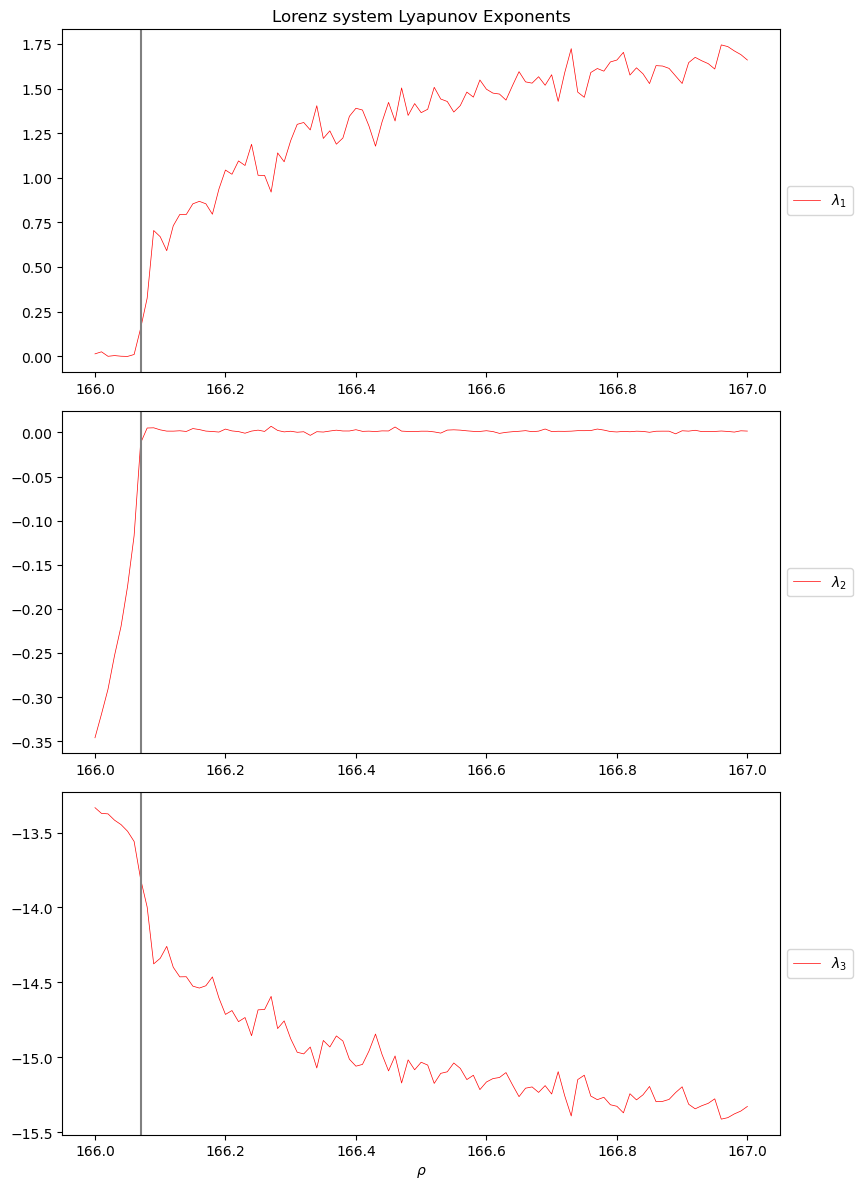

In [10]:
#######################################################################
# P L O T   D A T A
#######################################################################

# Plot Lorenz system Lyapunov Exponents
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  

axis_test_label = ["$\lambda_1$"     ,"$\lambda_2$"     ,"$\lambda_3$"     ]
axs[0].set_title("Lorenz system Lyapunov Exponents")

for i in range(n):
    axs[i].plot(rho_list, True_LE[:,i] , label= axis_test_label[i], color='red' , lw = 0.5)
    #
    # Shrink current axis by 20%
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    axs[i].axvline(x = 166.07   , color = 'grey')

axs[2].set_xlabel("$\\rho$") #\\rho need to prevent parsing error!!!
fig.tight_layout()

plt.show()

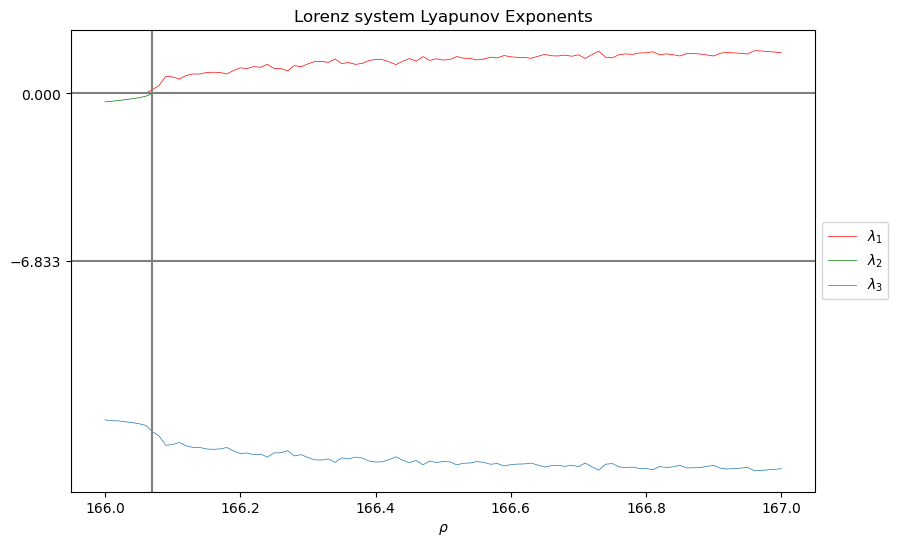

In [11]:
#######################################################################
# P L O T   D A T A   2
#######################################################################

# Plot Lorenz system Lyapunov Exponents
fig = plt.figure(figsize = (12,6)) 
ax  = fig.add_subplot(1, 1, 1)

axis_test_label = ["$\lambda_1$"     ,"$\lambda_2$"     ,"$\lambda_3$"     ]
ax.set_title("Lorenz system Lyapunov Exponents")

#ax.plot(rho_list, True_LE[:,0] , label= axis_test_label[0], color='red'  , marker='+',lw = 0.5)
#ax.plot(rho_list, True_LE[:,1] , label= axis_test_label[1], color='green', marker='+',lw = 0.5)
#ax.plot(rho_list, True_LE[:,2] , label= axis_test_label[2], color='C0'   , marker='+',lw = 0.5)
ax.plot(rho_list, True_LE[:,0] , label= axis_test_label[0], color='red'  , lw = 0.5)
ax.plot(rho_list, True_LE[:,1] , label= axis_test_label[1], color='green', lw = 0.5)
ax.plot(rho_list, True_LE[:,2] , label= axis_test_label[2], color='C0'   , lw = 0.5)
ax.plot(rho_list, 0*True_LE[:,0], color='black', lw = 0.5)
#
ax.axvline(x = 166.07   , color = 'grey')

ax.set_yticks([-(1+sigma + b)*0.5, 0])
ax.axhline(y = -(1+sigma + b)*0.5  , color = 'grey')
ax.axhline(y = 0  , color = 'grey')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("$\\rho$") #\\rho need to prevent parsing error!!!

plt.show()

In [ ]:
#---------------------------------------------------------------------#---------------------------------------------------------------------#
# Elapsed time
#---------------------------------------------------------------------#
print(f'\nElapsed time {time.time() - start_time:6.2e} s')